# Algorithm for Signal Attenuation Mask Detection - Example

In [1]:
import os
import subprocess
from pathlib import Path
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import hvplot.xarray
import hvplot.pandas
import echopype as ep
from echopype import open_raw
import echopype.visualize as epviz

from echopype.testing import TEST_DATA_FOLDER

warnings.simplefilter("ignore", category=DeprecationWarning)

**The code below ensures that test data is locally available by downloading it from the specified FTP server if it isn't found in the 'echopype/echopype/test_data' directory.**
- After ensuring the data is available, the code processes the raw sonar data to obtain the Volume Backscattering Strength (`source_Sv`) for analysis.
- A specific sonar frequency channel (`desired_channel`) is also defined for potential signal attenuation mask identification.

In [2]:
file_name = "JR161-D20061118-T010645.raw"
ftp_main = "ftp://ftp.bas.ac.uk"
ftp_partial_path = "/rapidkrill/ek60/"

test_data_path: str = os.path.join(
    TEST_DATA_FOLDER,
    file_name.upper(),
)


def set_up():
    "Gets the test data if it doesn't already exist"
    if not os.path.exists(TEST_DATA_FOLDER):
        os.mkdir(TEST_DATA_FOLDER)
    if not os.path.exists(test_data_path):
        ftp_file_path = ftp_main + ftp_partial_path + file_name
        print(ftp_file_path)
        print(test_data_path)
        subprocess.run(["wget", ftp_file_path, "-O", test_data_path])


def get_sv_dataset(file_path):
    set_up()
    ed = ep.open_raw(file_path, sonar_model="ek60")
    Sv = ep.calibrate.compute_Sv(ed).compute()
    return Sv, ed


source_Sv, ed = get_sv_dataset(test_data_path)
desired_channel = 'GPT  38 kHz 009072033fa5 1 ES38'

In [3]:
Sv_ds = source_Sv
source_Sv

<xarray.Dataset>
Dimensions:                        (channel: 3, ping_time: 403,
                                    range_sample: 5377, filenames: 1, time3: 403)
Coordinates:
  * channel                        (channel) object 'GPT  38 kHz 009072033fa5...
  * ping_time                      (ping_time) datetime64[ns] 2006-11-18T01:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 5374 5375 5376
  * filenames                      (filenames) int64 0
  * time3                          (time3) datetime64[ns] 2006-11-18T01:06:44...
Data variables: (12/16)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 3.8e+04 1.2e+05 2e+05
    sound_speed                    (channel, ping_time) float64 1.453e+03 ......
    sound_absorption               (channel, ping_time) float64 0.01007 ... 0...
    sa_correction                  (ping_time, channel) float64 -0.63 ... -0.31
    ...                             ...
    angle_sensitivity_alongship    (channel, ping_time) float64 22.0 ... 23.0
    angle_sensitivity_athwartship  (channel, ping_time) float64 22.0 ... 23.0
    beamwidth_alongship            (channel, ping_time) float64 6.96 ... 6.44
    beamwidth_athwartship          (channel, ping_time) float64 6.88 ... 6.43
    source_filenames               (filenames) <U118 '/Users/simedroniraluca/...
    water_level                    (channel, time3) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2285+g595ff46
    processing_time:              2023-08-20T12:00:19Z
    processing_function:          calibrate.compute_Sv

#   Signal attenuation
- This refers to the high reduction in signal strength as it travels through water. Factors like water temperature, salinity, and depth can affect the speed of sound in water and result in attenuation, thereby decreasing the quality of the received signal.

**Echogram before signal attenuation identification**

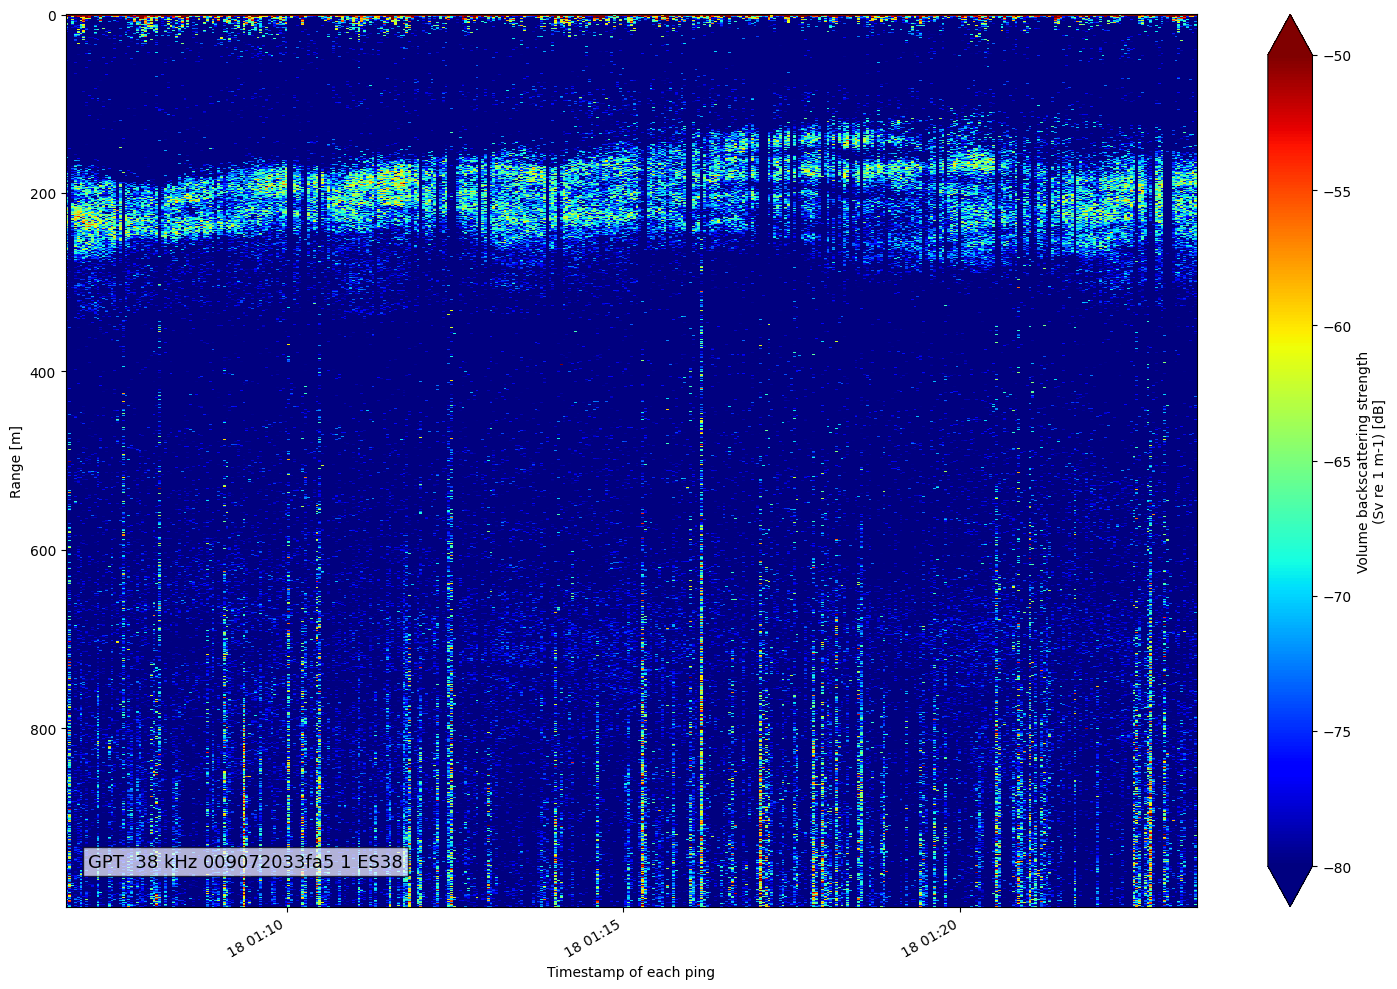

In [4]:
epviz.create_echogram(Sv_ds, channel=desired_channel, vmin=-80, vmax=-50)

**Specific masking technique**

**Ryan Method**
- Ryan et al. (2015) ‘Reducing bias due to noise and attenuation in open-ocean echo integration data’, ICES Journal of Marine Science, 72: 2482–2493.


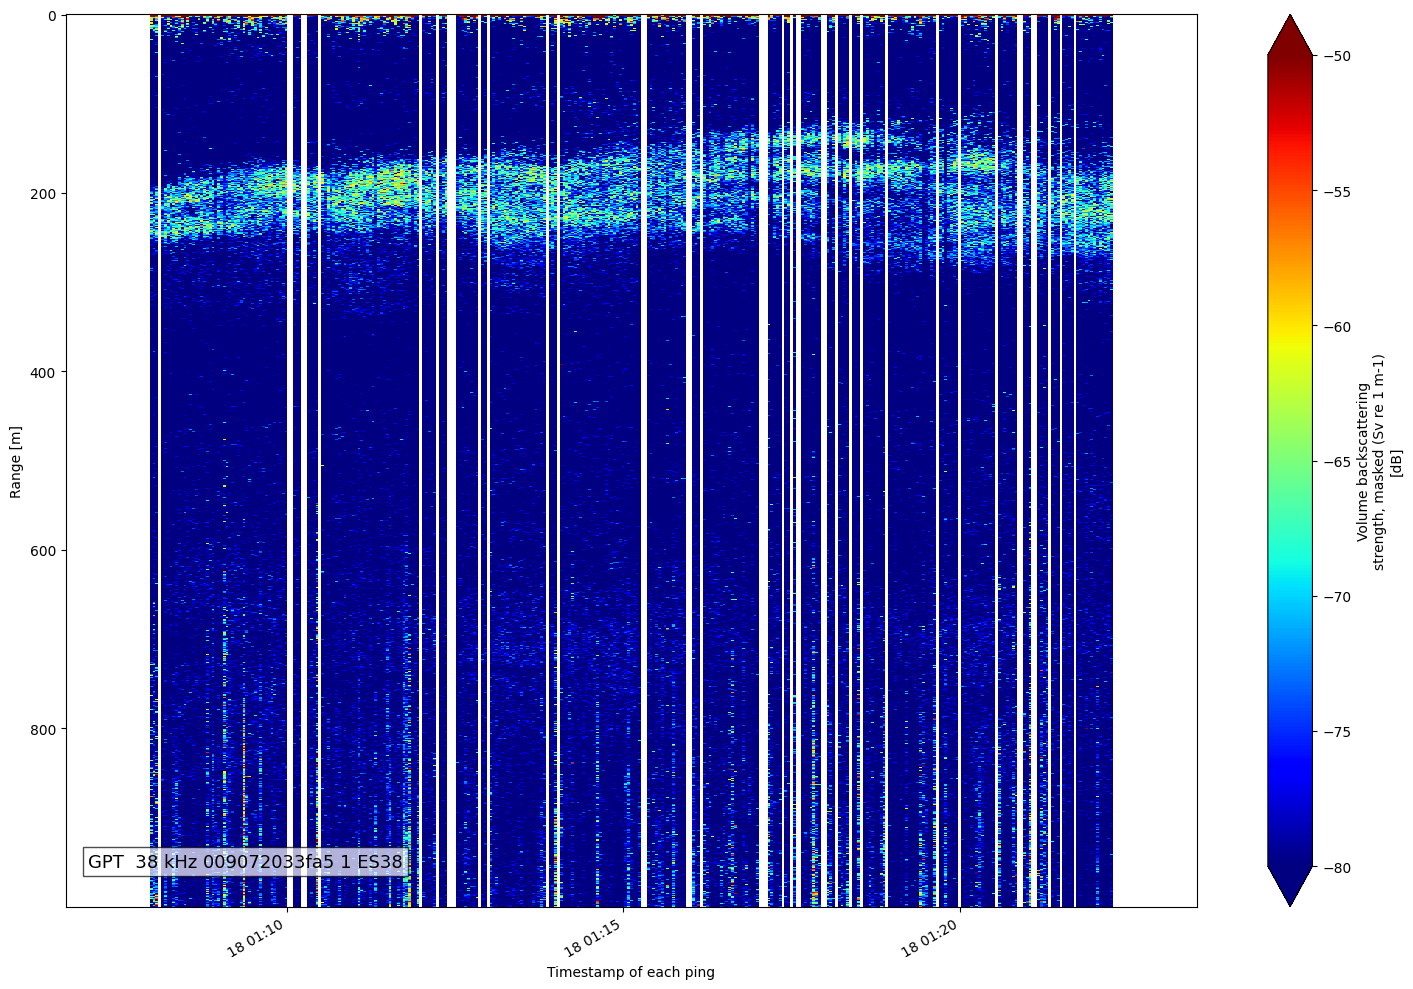

In [5]:
mask = ep.mask.get_attenuation_mask(Sv_ds,"ryan",r0=180, r1=280, n=30, thr=-6)
clean_Sv_ds = ep.mask.apply_mask(Sv_ds,mask)
epviz.create_echogram(clean_Sv_ds,channel=desired_channel,vmin=-80,vmax=-50)